<a href="https://colab.research.google.com/github/carvalheiracarlos/scikit-maad-Rois/blob/main/ROIs_scikit_maad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.4 MB/s eta 0:00:00


In [4]:
import glob
import numpy as np
import pandas as pd
from maad import sound, rois, features
from maad.util import (power2dB, plot2d, format_features, read_audacity_annot,
                       overlay_rois, overlay_centroid)

In [2]:
def list_wav_files(relative_path: str, file_extension: str):
  path = relative_path + file_extension
  return glob.glob(path)

In [5]:
files = list_wav_files('./*', '.wav')
print(files)

['./PMpiloto_2018_20181121_220136_337.wav']


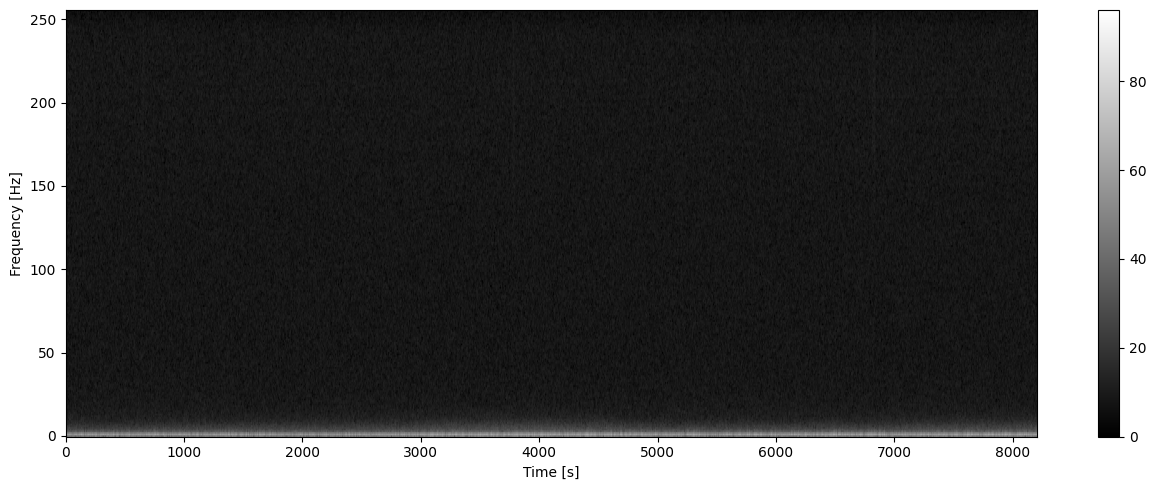

(<Axes: xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1300x500 with 2 Axes>)

In [16]:
s, fs = sound.load(files[0])

dB_max = 96 

Sxx_power, tn, fn, ext = sound.spectrogram(s, fs, nperseg=512, noverlap=512//2)


Sxx_db = power2dB(Sxx_power) + dB_max
plot2d(Sxx_db, **{'vmin':0, 'vmax':dB_max})

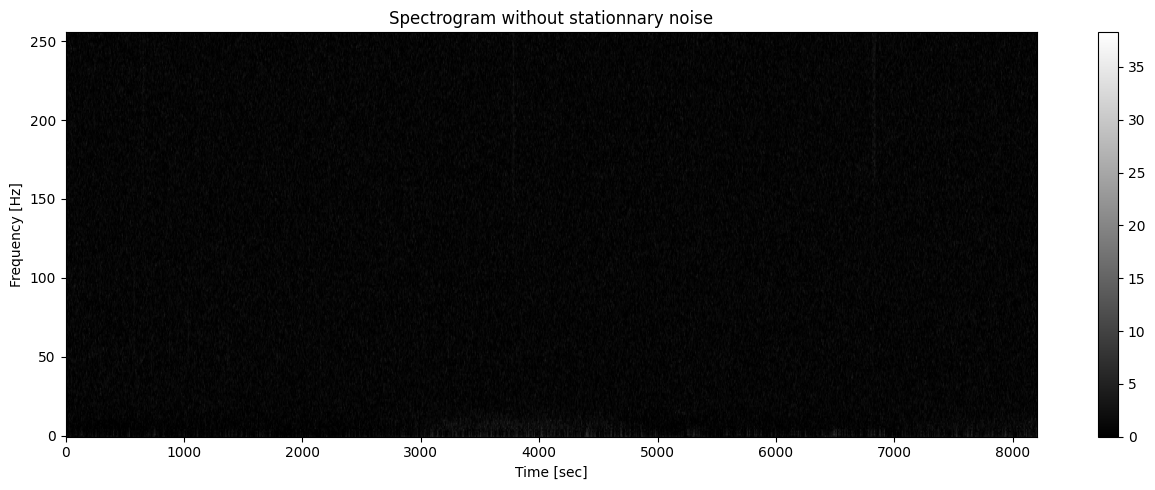

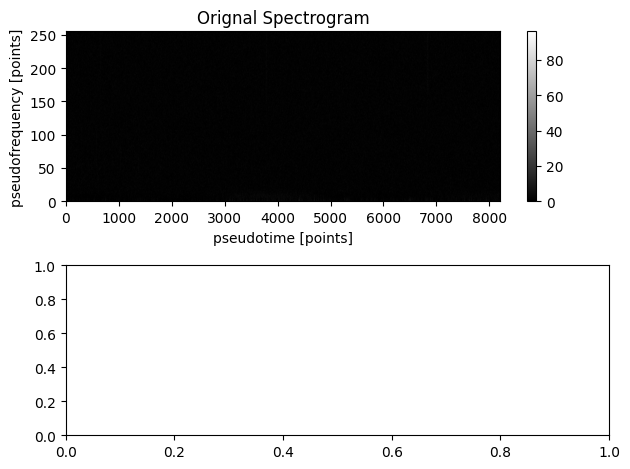

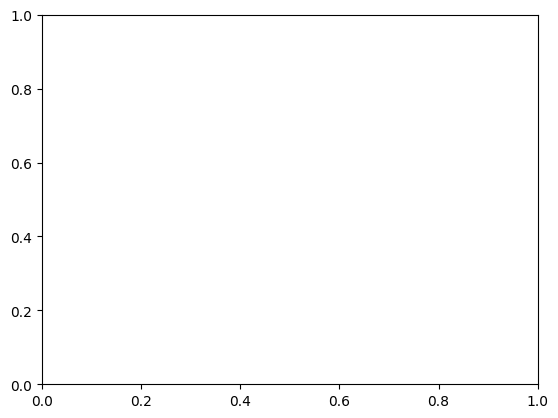

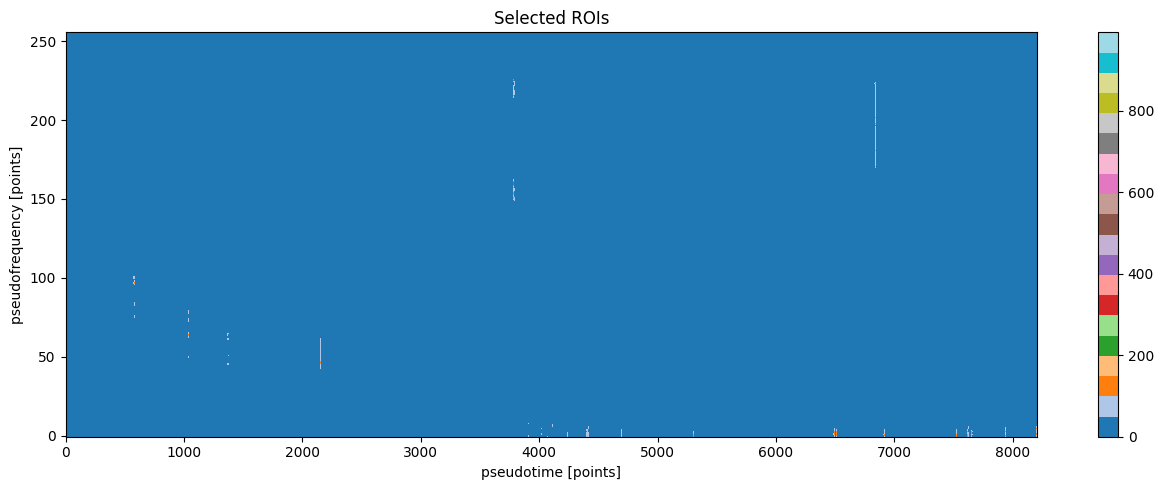

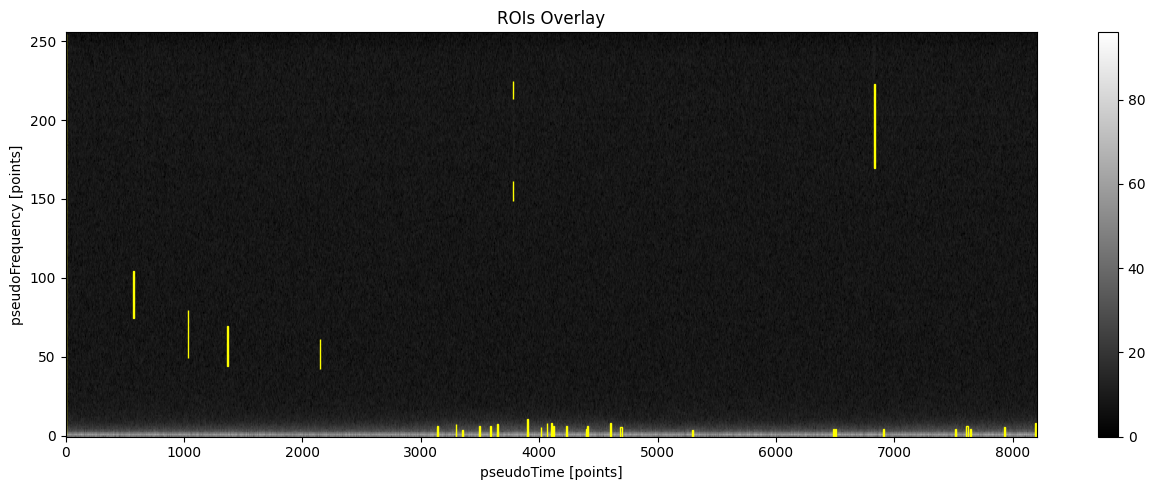

In [18]:
# First we remove the stationary background in order to increase the contrast [1]
# Then we convert the spectrogram into dB
Sxx_power_noNoise= sound.median_equalizer(Sxx_power, display=True)
Sxx_db_noNoise = power2dB(Sxx_power_noNoise)

# Then we smooth the spectrogram in order to facilitate the creation of masks as
# small sparse details are merged if they are close to each other
Sxx_db_noNoise_smooth = sound.smooth(Sxx_db_noNoise, std=0.5,
                         display=True, savefig=None,
                         **{'vmin':0, 'vmax':dB_max})

# Then we create a mask (i.e. binarization of the spectrogram) by using the
# double thresholding technique
im_mask = rois.create_mask(im=Sxx_db_noNoise_smooth, mode_bin ='relative',
                           bin_std=8, bin_per=0.5,
                           verbose=False, display=False)

# Finaly, we put together pixels that belong to the same acoustic event, and
# remove very small events (<=25 pixel²)
im_rois, df_rois = rois.select_rois(im_mask, min_roi=25, max_roi=None,
                                 display= True)

# format dataframe df_rois in order to convert pixels into time and frequency
df_rois = format_features(df_rois, tn, fn)

# overlay bounding box on the original spectrogram
ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':dB_max})

# Compute and visualize centroids
df_centroid = features.centroid_features(Sxx_db, df_rois, im_rois)
df_centroid = format_features(df_centroid, tn, fn)
ax0, fig0 = overlay_centroid(Sxx_db, df_centroid, savefig=None,
                             **{'vmin':0,'vmax':dB_max,'ms':4,
                                'marker':'+', 'color':'red',
                                'fig':fig0, 'ax':ax0})